In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, LeaveOneGroupOut
import gc
from fastai import *
from fastai.tabular import *
from pytorch_toolbelt import losses as L

In [2]:
train = pd.read_csv("/home/shanmugam/fastai/ion/CAX_LogFacies_Train_File.csv")

In [44]:
train = pd.read_csv("/home/shanmugam/fastai/ion/data-without-drift/train_clean.csv")
test = pd.read_csv("/home/shanmugam/fastai/ion/data-without-drift/test_clean.csv")

In [3]:
ss = pd.read_csv("/home/shanmugam/fastai/ion/sample_submission.csv", dtype={'time':str})

In [45]:
train['filter'] = 0
test['filter'] = 2

In [46]:
ts1 = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)

In [47]:
ts1['time2'] = pd.cut(ts1['time'], bins=np.linspace(0.0000, 700., num=14 + 1), labels=list(range(14)), include_lowest=True).astype(int)

In [48]:
np.random.seed(321)
ts1['group'] = pd.cut(ts1['time'], bins=np.linspace(0.0000, 700., num=14*125 + 1), labels=list(range(14*125)), include_lowest=True).astype(int)

In [49]:
np.random.seed(321)

y = ts1.loc[ts1['filter']==0, 'open_channels']
group = ts1.loc[ts1['filter']==0, 'group']
X = ts1.loc[ts1['filter']==0, 'signal']

In [50]:
np.random.seed(321)
skf = GroupKFold(n_splits=5)
splits = [x for x in skf.split(X, y, group)]

In [51]:
use_cols = [col for col in ts1.columns if col not in ['index','filter','group', 'open_channels', 'time', 'time2']] 

In [52]:
for col in use_cols:
    col_mean = ts1[col].mean()
    ts1[col] = ts1[col].fillna(col_mean)

In [53]:
val_preds_all = np.zeros((ts1[ts1['filter']==0].shape[0], 11))
test_preds_all = np.zeros((ts1[ts1['filter']==2].shape[0], 11))

In [54]:
times = ts1.loc[ts1['filter']==0, 'time']
groups = ts1.loc[ts1['filter']==0, 'group']

In [55]:
new_splits = []
for sp in splits:
    new_split = []
    new_split.append(np.unique(groups[sp[0]]))
    new_split.append(np.unique(groups[sp[1]]))
    new_splits.append(new_split)

In [18]:
ts1[ts1['filter']==0].groupby('group').apply(lambda x: x[use_cols].values)

group
0       [[-2.76], [-2.8557], [-2.4074], [-3.1404], [-3...
1       [[-2.7315], [-2.966], [-2.905], [-2.713], [-2....
2       [[-2.7916], [-2.7168], [-2.9530000000000003], ...
3       [[-2.6076], [-2.7435], [-2.798], [-3.069], [-2...
4       [[-2.8839], [-2.9509], [-3.0634], [-3.188], [-...
                              ...                        
1245    [[3.9097650003934232], [3.5378961686331207], [...
1246    [[3.3394226830619003], [4.49855394039967], [5....
1247    [[5.48969729903853], [6.9973286257316065], [5....
1248    [[4.369009785352983], [5.399041161614716], [5....
1249    [[1.3412809287908494], [3.3961123348033384], [...
Length: 1250, dtype: object

In [56]:
trainval = np.array(list(ts1[ts1['filter']==0].groupby('group').apply(lambda x: x[use_cols].values)))
test = np.array(list(ts1[ts1['filter']==2].groupby('group').apply(lambda x: x[use_cols].values)))
trainval_y = np.array(list(ts1[ts1['filter']==0].groupby('group').apply(lambda x: x[['open_channels']].values)))

In [57]:
trainval.shape

(1250, 4000, 1)

In [16]:
# transpose to B x C x L
trainval = trainval.transpose((0,2,1))
test = test.transpose((0,2,1))

In [17]:
trainval_y = trainval_y.reshape(trainval_y.shape[:2])
test_y = np.zeros((test.shape[0], trainval_y.shape[1]))

In [2]:
from fastai.tabular import *
?FloatList

In [24]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize

    def load_best_weights(self, model):
        model.load_state_dict(torch.load(self.checkpoint_path))

    def __call__(self, score, model):
        if self.best_score is None or \
        (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    
class Seq2SeqRnn(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, output_size, num_layers=1, bidirectional=False, dropout=.3,
            hidden_layers = [100, 200]):
        
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.bidirectional=bidirectional
        self.output_size=output_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                           bidirectional=bidirectional, batch_first=True,dropout=0.5)
#         self.relu = [nn.ReLU(inplace=True)]
        self.bn = BatchNorm1dFlat(hidden_size*2)
        
         # Input Layer
        if hidden_layers and len(hidden_layers):
            
#             first_layer  = nn.Linear(hidden_size*2 if bidirectional else hidden_size, hidden_layers[0])
            first_layer  = nn.Linear(hidden_size*2 if bidirectional else hidden_size, hidden_layers[0])

            # Hidden Layers
            for i in range(len(hidden_layers) - 1):
                self.hidden_layers = nn.ModuleList(
                    [first_layer]+ [nn.ReLU] + [BatchNorm1dFlat(hidden_layers[i])] + [nn.Linear(hidden_layers[i], hidden_layers[i+1])] 
                )
#             self.hidden_layers = nn.ModuleList(
#                 [first_layer]+[nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)]
#             )
            nn.init.kaiming_normal_(self.hidden_layers[0].weight.data)   
            nn.init.kaiming_normal_(self.hidden_layers[3].weight.data)  
#             for layer in self.hidden_layers: nn.init.kaiming_normal_(layer.weight.data) 
#             self.intermediate_layer = nn.Linear(hidden_layers[-1], self.input_size)
            self.intermediate_layer = nn.ModuleList([nn.ReLU] + 
                [BatchNorm1dFlat(hidden_layers[-1])] + [nn.Linear(hidden_layers[-1], self.input_size)])
#             output layers
            self.output_layer = nn.ModuleList([nn.ReLU] + [BatchNorm1dFlat(hidden_layers[-1])] + [nn.Linear(hidden_layers[-1], output_size)])
            
            nn.init.kaiming_normal_(self.output_layer[2].weight.data) 
#             self.output_layer = nn.Linear(hidden_layers[-1], output_size)
#             nn.init.kaiming_normal_(self.output_layer.weight.data) 
        else:
            self.hidden_layers = []
            self.intermediate_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_siz, self.input_size)
            self.output_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_size)
            nn.init.kaiming_normal_(self.output_layer.weight.data) 

        self.activation_fn = torch.relu
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size = x.size(0)
        pdb.set_trace()
        x = x.permute(0,2,1)
        outputs, hidden = self.rnn(x)        
        
        x = self.dropout(self.bn(self.activation_fn(outputs)))
#         x = self.dropout(self.activation_fn(outputs))
#         x = self.dropout(self.bn(outputs))
        for hidden_layer in self.hidden_layers:
#             x = self.activation_fn(hidden_layer(x))
#             x = nn.BatchNorm1d(x)
            x = self.dropout(x)
            
        x = self.output_layer(x)

        return x


class IonDataset(Dataset):
    """Car dataset."""

    def __init__(self, data, labels, training=True, transform=None, flip=0.5, noise_level=0, class_split=0.0):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.training = training
        self.flip = flip
        self.noise_level = noise_level
        self.class_split = class_split

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.data[idx]
        labels = self.labels[idx]
        if np.random.rand() < self.class_split:
            data, labels = class_split(data, labels)
        if  np.random.rand() < self.noise_level:
            data = data * torch.FloatTensor(10000).uniform_(1-self.noise_level, 1+self.noise_level)
        if np.random.rand() < self.flip:
            data = torch.flip(data, dims=[1])
            labels = np.flip(labels, axis=0).copy().astype(int)

        return [data, labels.astype(int)]

In [19]:
trainval = torch.Tensor(trainval)
test = torch.Tensor(test)

In [20]:
import pdb
for index, (train_index, val_index ) in enumerate(new_splits[0:], start=0):
    print(index)

0
1
2
3
4


In [25]:
batchsize = 16
train_dataset = IonDataset(trainval[train_index],  trainval_y[train_index], flip=False, noise_level=0.0, class_split=0.0)
train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=8, pin_memory=True)

valid_dataset = IonDataset(trainval[val_index],  trainval_y[val_index], flip=False)
valid_dataloader = DataLoader(valid_dataset, batchsize, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = IonDataset(test,  test_y, flip=False, noise_level=0.0, class_split=0.0)
test_dataloader = DataLoader(test_dataset, batchsize, shuffle=False, num_workers=8, pin_memory=True)
test_preds_iter = np.zeros((2000000, 11))
it = 0
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model=Seq2SeqRnn(input_size=trainval.shape[1], seq_len=4000, hidden_size=128, output_size=11, num_layers=2, hidden_layers=[64,64,64],
                         bidirectional=True).to(device)
tab_db = DataBunch(train_dataloader,valid_dataloader,test_dl=test_dataloader)
learn = Learner(tab_db,model,metrics=accuracy)
learn.loss_func = L.FocalLoss()
# pdb.set_trace()
learn.fit_one_cycle(5,max_lr=1e-03)
# learn.lr_find()
# learn.recorder.plot()

TypeError: torch.nn.modules.activation.ReLU is not a Module subclass

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


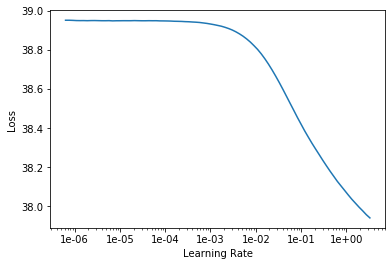

In [22]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5,max_lr=1e-03,wd=0.2) #4 	0.168433 	0.088413 	0.952356 	00:37

epoch,train_loss,valid_loss,accuracy,time
0,38.832249,35.326225,0.258593,01:13
1,38.334431,32.964149,0.258593,01:13
2,37.927860,31.488235,0.258593,01:14


KeyboardInterrupt: 

In [24]:
learn.fit_one_cycle(5,max_lr=1e-03,wd=0.2) #4 	0.105642 	0.062846 	0.959638 	00:37

epoch,train_loss,valid_loss,accuracy,time
0,37.084267,22.830458,0.258593,01:19
1,37.082474,22.637161,0.258593,01:13
2,37.079102,22.398207,0.258574,01:13
3,37.077084,22.237785,0.258593,01:13
4,37.076225,22.202454,0.258593,01:13


In [26]:
learn.fit_one_cycle(10,max_lr=2,wd=0.2) #9 	0.077487 	0.052689 	0.965836 	00:37

epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.258593,01:13
1,nan,nan,0.258593,01:13
2,nan,nan,0.258593,01:13
3,nan,nan,0.258593,01:13
4,nan,nan,0.258593,01:13
5,nan,nan,0.258593,01:13
6,nan,nan,0.258593,01:13
7,nan,nan,0.258593,01:19
8,nan,nan,0.258593,01:13
9,nan,nan,0.258593,01:13


In [121]:
learn.fit_one_cycle(20,max_lr=1e-03,wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.077504,0.052646,0.965893,00:37
1,0.075643,0.052545,0.965881,00:37
2,0.075885,0.052111,0.966223,00:37
3,0.074461,0.052644,0.965718,00:37
4,0.072923,0.051417,0.965740,00:37
5,0.071123,0.050809,0.965617,00:37
6,0.069802,0.050763,0.965054,00:37
7,0.068603,0.049812,0.965990,00:38
8,0.067997,0.049176,0.966812,00:37
9,0.066466,0.049494,0.966660,00:38


In [126]:
learn.fit_one_cycle(5,max_lr=1e-04,wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,0.058972,0.047453,0.967437,00:37
1,0.060869,0.047358,0.967298,00:38
2,0.059651,0.047538,0.966973,00:37
3,0.060599,0.048216,0.966734,00:38
4,0.062677,0.047507,0.966986,00:37
5,0.108158,0.054906,0.964487,00:37
6,0.077356,0.048419,0.966872,00:37
7,0.066978,0.047832,0.966939,00:38
8,0.062759,0.047731,0.967206,00:38
9,0.062792,0.047389,0.967272,00:38


In [129]:
learn.fit_one_cycle(5,max_lr=1e-05,wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,0.060139,0.046635,0.967425,00:40
1,0.059982,0.046715,0.967444,00:37
2,0.059452,0.046654,0.967440,00:37
3,0.058777,0.046662,0.967441,00:37
4,0.058645,0.046662,0.967451,00:37


In [131]:
learn.fit_one_cycle(5,max_lr=1e-03/2,wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.059947,0.047304,0.966473,00:40
1,0.060153,0.046842,0.967079,00:38
2,0.058917,0.046621,0.967440,00:38
3,0.058592,0.046483,0.967489,00:38
4,0.058787,0.046536,0.967511,00:38


In [132]:
learn.save('model938')

In [31]:
tab_db = DataBunch(train_dataloader,valid_dataloader,test_dl=test_dataloader)

In [90]:
import sys

In [70]:
learn

Learner(data=DataBunch;

Train: <__main__.IonDataset object at 0x7fa4d4d42890>;

Valid: <__main__.IonDataset object at 0x7fa4d4e89910>;

Test: <__main__.IonDataset object at 0x7fa4b38fe290>, model=Seq2SeqRnn(
  (rnn): GRU(1, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (bn): BatchNorm1dFlat(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (intermediate_layer): ModuleList(
    (0): ReLU(inplace=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_layer): ModuleList(
    (0): ReLU(inplace=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [127]:
with torch.no_grad():
            pred_list = []
            for x, y in test_dataloader:
                x = x.to(device)
                y = y.to(device)

                predictions = model(x[:,:trainval.shape[1],:])
                predictions_ = predictions.view(-1, predictions.shape[-1]) 

                pred_list.append(F.softmax(predictions_, dim=1).cpu().numpy())
            test_preds = np.vstack(pred_list)
test_preds_iter += test_preds
test_preds_all += test_preds
if not os.path.exists("./predictions/test"):
    os.makedirs("./predictions/test")
np.save('./predictions/test/gru_clean_fold_{}_iter_{}_raw.npy'.format(index, it), arr=test_preds_iter)
np.save('./predictions/test/gru_clean_fold_{}_raw.npy'.format(index), arr=test_preds_all)

test_preds_all = test_preds_all/np.sum(test_preds_all, axis=1)[:, None]
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str),
                                'open_channels': np.argmax(test_preds_all, axis=1)})
test_pred_frame.to_csv("./sub_gru.csv", index=False)
                

In [124]:
test_preds.shape

(2000000, 11)

In [106]:
%debug
preds, _ = learn.get_preds(DatasetType.Test)

> /home/shanmugam/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py(32)loss_batch()
     30 #    out_ = out.view(-1, out.shape[-1])
     31 #    y_ = yb[0].view(-1)
---> 32     loss = loss_func(out, *yb)
     33 #    loss = loss_func(out_, y_)
     34     if opt is not None:

ipdb> u
> /home/shanmugam/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py(61)validate()
     59         if cb_handler: cb_handler.set_dl(dl)
     60         for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None)):
---> 61             if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
     62             val_loss = loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler)
     63             val_losses.append(val_loss)

ipdb> u
> /home/shanmugam/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py(46)get_preds()
     44     "Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`."
     45 
---> 46     r

ipdb> p xb
*** NameError: name 'xb' is not defined
ipdb> p val_losses
*** NameError: name 'val_losses' is not defined
ipdb> l
     74     model.train()
     75     for xb,yb in dl:
     76         loss = loss_func(model(xb), yb)
     77         loss.backward()
     78         opt.step()
     79         opt.zero_grad()
     80 
     81 @dataclass
     82 class BasicLearner():
     83     model:nn.Module
     84     loss_func:LossFunction

ipdb> l
     85     opt:optim.Optimizer
     86     data:DataBunch
     87 
     88 def fit(epochs:int, learn:BasicLearner, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
     89     "Fit the `model` on `data` and learn using `loss_func` and `opt`."
     90     assert len(learn.data.train_dl) != 0, f"""Your training dataloader is empty, can't train a model.
     91         Use a smaller batch size (batch size={learn.data.train_dl.batch_size} for {len(learn.data.train_dl.dataset)} elements)."""
     92     cb_handler = CallbackHa

TypeError: 'NoneType' object is not callable

In [21]:
for index, (train_index, val_index ) in enumerate(new_splits[0:], start=0):
    print("Fold : {}".format(index))
    
    batchsize = 16
    train_dataset = IonDataset(trainval[train_index],  trainval_y[train_index], flip=False, noise_level=0.0, class_split=0.0)
    train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=8, pin_memory=True)

    valid_dataset = IonDataset(trainval[val_index],  trainval_y[val_index], flip=False)
    valid_dataloader = DataLoader(valid_dataset, batchsize, shuffle=False, num_workers=4, pin_memory=True)

    test_dataset = IonDataset(test,  test_y, flip=False, noise_level=0.0, class_split=0.0)
    test_dataloader = DataLoader(test_dataset, batchsize, shuffle=False, num_workers=8, pin_memory=True)
    test_preds_iter = np.zeros((2000000, 11))
    it = 0
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    model=Seq2SeqRnn(input_size=trainval.shape[1], seq_len=4000, hidden_size=64, output_size=11, num_layers=2, hidden_layers=[64,64,64],
                         bidirectional=True).to(device)
    tab_db = DataBunch(train_dataloader,valid_dataloader,test_dataloader)
    learn = Learner(tab_db,model,metrics=accuracy)
    learn.loss_func = L.FocalLoss()
    pdb.set_trace()
    learn.fit_one_cycle(1,max_lr=1e-03)
    

Fold : 0
> <ipython-input-21-94d360abc00d>(22)<module>()
-> learn.fit_one_cycle(1,max_lr=1e-03)
(Pdb) c


epoch,train_loss,valid_loss,accuracy,time
0,1.146713,0.719118,0.340028,00:40


Fold : 1
> <ipython-input-21-94d360abc00d>(21)<module>()
-> pdb.set_trace()
(Pdb) c


epoch,train_loss,valid_loss,accuracy,time
0,1.153987,0.724897,0.299304,00:38


Fold : 2
> <ipython-input-21-94d360abc00d>(22)<module>()
-> learn.fit_one_cycle(1,max_lr=1e-03)
(Pdb) c


epoch,train_loss,valid_loss,accuracy,time
0,1.315211,0.745958,0.424823,00:39


Fold : 3
> <ipython-input-21-94d360abc00d>(21)<module>()
-> pdb.set_trace()
(Pdb) c


epoch,train_loss,valid_loss,accuracy,time
0,1.182423,0.651028,0.445214,00:38


Fold : 4
> <ipython-input-21-94d360abc00d>(22)<module>()
-> learn.fit_one_cycle(1,max_lr=1e-03)
(Pdb) c


epoch,train_loss,valid_loss,accuracy,time
0,1.050273,0.600786,0.614630,00:37


In [37]:
for index, (train_index, val_index ) in enumerate(new_splits[0:], start=0):
    print("Fold : {}".format(index))
    
    batchsize = 16
    train_dataset = IonDataset(trainval[train_index],  trainval_y[train_index], flip=False, noise_level=0.0, class_split=0.0)
    train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=8, pin_memory=True)

    valid_dataset = IonDataset(trainval[val_index],  trainval_y[val_index], flip=False)
    valid_dataloader = DataLoader(valid_dataset, batchsize, shuffle=False, num_workers=4, pin_memory=True)

    test_dataset = IonDataset(test,  test_y, flip=False, noise_level=0.0, class_split=0.0)
    test_dataloader = DataLoader(test_dataset, batchsize, shuffle=False, num_workers=8, pin_memory=True)
    test_preds_iter = np.zeros((2000000, 11))
    it = 0
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    model=Seq2SeqRnn(input_size=trainval.shape[1], seq_len=4000, hidden_size=64, output_size=11, num_layers=2, hidden_layers=[64,64,64],
                         bidirectional=True).to(device)
    for it in range(1):
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        model=Seq2SeqRnn(input_size=trainval.shape[1], seq_len=4000, hidden_size=64, output_size=11, num_layers=2, hidden_layers=[64,64,64],
                         bidirectional=True).to(device)
    
        no_of_epochs = 1
        early_stopping = EarlyStopping(patience=20, is_maximize=True, checkpoint_path="./models/gru_clean_checkpoint_fold_{}_iter_{}.pt".format(index, it))
        criterion = L.FocalLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, max_lr=0.001, epochs=no_of_epochs,
                                                steps_per_epoch=len(train_dataloader))
        avg_train_losses, avg_valid_losses = [], [] 
    
    
        for epoch in range(no_of_epochs):
#             start_time = time.time()
    
            print("Epoch : {}".format(epoch))
            print( "learning_rate: {:0.9f}".format(schedular.get_lr()[0]))
            train_losses, valid_losses = [], []
    
            model.train() # prep model for training
            train_preds, train_true = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
    
            for x, y in train_dataloader:
                x = x.to(device)
                y = y.to(device)
    
                optimizer.zero_grad()
                
                predictions = model(x)
                
                predictions_ = predictions.view(-1, predictions.shape[-1]) 
                y_ = y.view(-1)
                print(predictions.shape,y.shape)
                print(predictions_.shape, y_.shape)
                loss = criterion(predictions_, y_)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                schedular.step()
                # record training lossa
                train_losses.append(loss.item())
    
                train_true = torch.cat([train_true, y_], 0)
                train_preds = torch.cat([train_preds, predictions_], 0)

            model.eval() # prep model for evaluation
            val_preds, val_true = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
            with torch.no_grad():
                for x, y in valid_dataloader:
                    x = x.to(device)
                    y = y.to(device)
    
                    predictions = model(x[:,:trainval.shape[1],:])
                    predictions_ = predictions.view(-1, predictions.shape[-1]) 
                    y_ = y.view(-1)
    
                    loss = criterion(predictions_, y_)
                    valid_losses.append(loss.item())
        
                    val_true = torch.cat([val_true, y_], 0)
                    val_preds = torch.cat([val_preds, predictions_], 0)

            # calculate average loss over an epoch
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            avg_train_losses.append(train_loss)
            avg_valid_losses.append(valid_loss)
            
            print( "train_loss: {:0.6f}, valid_loss: {:0.6f}".format(train_loss, valid_loss))

            train_score = f1_score(train_true.cpu().detach().numpy(), train_preds.cpu().detach().numpy().argmax(1), labels=list(range(11)), average='macro')
    
            val_score = f1_score(val_true.cpu().detach().numpy(), val_preds.cpu().detach().numpy().argmax(1), labels=list(range(11)), average='macro')
            print( "train_f1: {:0.6f}, valid_f1: {:0.6f}".format(train_score, val_score))
    
            if early_stopping(val_score, model):
                print("Early Stopping...")
                print("Best Val Score: {:0.6f}".format(early_stopping.best_score))
                break
    
            print("--- %s seconds ---" % (time.time() - start_time))
        
        model.load_state_dict(torch.load("./models/gru_clean_checkpoint_fold_{}_iter_{}.pt".format(index, it)))
        with torch.no_grad():
            pred_list = []
            for x, y in test_dataloader:
                x = x.to(device)
                y = y.to(device)

                predictions = model(x[:,:trainval.shape[1],:])
                predictions_ = predictions.view(-1, predictions.shape[-1]) 

                pred_list.append(F.softmax(predictions_, dim=1).cpu().numpy())
            test_preds = np.vstack(pred_list)
       
        test_preds_iter += test_preds
        test_preds_all += test_preds
        if not os.path.exists("./predictions/test"):
            os.makedirs("./predictions/test")
        np.save('./predictions/test/gru_clean_fold_{}_iter_{}_raw.npy'.format(index, it), arr=test_preds_iter)
        np.save('./predictions/test/gru_clean_fold_{}_raw.npy'.format(index), arr=test_preds_all)

# test_preds_all = test_preds_all/np.sum(test_preds_all, axis=1)[:, None]
# test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str),
#                                 'open_channels': np.argmax(test_preds_all, axis=1)})
# test_pred_frame.to_csv("./gru_preds.csv", index=False)
    

Fold : 0
Epoch : 0
learning_rate: 0.000001000
torch.Size([16, 4000, 11]) torch.Size([16, 4000])
torch.Size([64000, 11]) torch.Size([64000])
torch.Size([16, 4000, 11]) torch.Size([16, 4000])
torch.Size([64000, 11]) torch.Size([64000])
torch.Size([16, 4000, 11]) torch.Size([16, 4000])
torch.Size([64000, 11]) torch.Size([64000])
torch.Size([16, 4000, 11]) torch.Size([16, 4000])
torch.Size([64000, 11]) torch.Size([64000])
torch.Size([16, 4000, 11]) torch.Size([16, 4000])
torch.Size([64000, 11]) torch.Size([64000])


KeyboardInterrupt: 

In [161]:
doc(Learner)

In [ ]:
Target size (torch.Size([16, 4000])) must be the same as input size (torch.Size([16, 11]))

In [155]:

L.FocalLoss?

In [5]:
X_train = pd.pivot_table(train, values='GR', index=['well_id'], columns=['row_id'])
y_train = pd.pivot_table(train, values='label', index=['well_id'], columns=['row_id'])

In [44]:
X_train.head()

row_id,0,1,2,3,4,5,6,7,8,9,...,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099
well_id,,,,,,,,,,,,,,,,,,,,,
0,143.51,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,...,142.881647,137.732575,145.843503,133.434431,144.205359,139.136288,158.257216,139.508144,130.589072,154.93
1,122.26,112.872757,120.125514,122.488271,132.111028,117.603785,117.206542,114.179299,115.182056,118.134813,...,150.295187,150.337944,133.380701,155.813458,159.656215,158.788972,139.421729,157.724486,159.127243,137.45
2,125.94,121.713658,112.027316,115.600974,129.104631,111.938289,132.901947,110.015605,118.769263,108.452921,...,137.417079,150.210737,152.374395,143.668053,136.331711,134.055369,148.719026,153.752684,134.256342,151.32
3,109.03,122.551838,122.963676,113.355514,115.347352,124.439190,118.081028,133.792866,120.034704,104.266542,...,150.073458,156.795296,149.217134,144.178972,135.520810,139.422648,156.184486,143.236324,125.958162,149.23
4,109.01,132.092739,111.845478,105.268217,115.480955,110.033694,130.016433,117.889172,113.621911,108.794650,...,150.875350,121.358089,139.830828,130.123567,143.416306,138.229045,121.911783,137.074522,124.117261,133.20


In [45]:
y_train.head()

row_id,0,1,2,3,4,5,6,7,8,9,...,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099
well_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from sklearn.model_selection import KFold
folds = KFold(n_splits=5, random_state=100, shuffle=True)
indices= [(train_index, test_index) for (train_index, test_index) in folds.split(X_train.index)]

In [47]:
indices[0][1]

array([   4,    5,    8,   10,   12,   16,   25,   28,   29,   31,   44,
         56,   57,   63,   65,   66,   68,   69,   71,   80,   93,   97,
         98,  103,  105,  107,  110,  116,  117,  130,  134,  138,  139,
        149,  150,  151,  153,  159,  160,  167,  174,  182,  185,  190,
        205,  211,  213,  219,  221,  229,  231,  242,  247,  249,  258,
        259,  263,  269,  288,  290,  291,  294,  302,  308,  309,  314,
        316,  317,  323,  328,  332,  338,  342,  344,  349,  352,  353,
        355,  356,  359,  362,  366,  367,  370,  385,  388,  403,  408,
        411,  413,  416,  423,  427,  432,  434,  435,  440,  444,  452,
        459,  463,  469,  480,  486,  492,  496,  504,  510,  519,  521,
        525,  526,  530,  532,  534,  536,  547,  551,  552,  553,  564,
        576,  585,  591,  593,  595,  598,  601,  605,  610,  614,  616,
        621,  622,  629,  631,  642,  646,  647,  650,  652,  656,  669,
        672,  676,  679,  686,  687,  688,  699,  7